# 1. Imports, Data Loading, and Dataset Creation

In [1]:
import sys
import os

# Get the directory path of the notebook
notebook_directory = os.path.dirname(os.path.abspath("__file__"))

# Get the directory path of the project (one level up)
project_directory = os.path.dirname(notebook_directory)

# Add the project directory to the Python module search path
sys.path.append(project_directory)

# Now you can import the LoadJSON module from DataLoaderLocal
from shared_utilities.DataLoaderLocal import LoadReviews

import pandas as pd
import utility_func as utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Adjust display options to show all columns
pd.set_option('display.max_columns', None)

In [2]:
reviews = LoadReviews()

utils.YelpDatasets_Reviews(reviews_df = reviews)


Reviews DataFrame's head:


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
14,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05
75,ymhbOMW63B_vGaRFR3XT0A,yZdAhQ_KmKuCZmbBy9YDQg,5Ce3lZksYVkCbrihqylVHQ,5,0,0,0,I just started going to Sushi Nara this month ...,2014-07-25 17:56:26
93,onlgwy5qGDEzddsrnIvtWg,pYXeL0RCqus2IfhthYCOyA,W7NxQw8UYFR0HLPrI08tvw,4,0,0,0,Don't know what it is but If my tummy's feelin...,2012-02-01 14:21:25
147,ypFqmURIY41F4pWaMW1VrQ,hToW2eoTAYlOcuNz7I73Cg,7L1kXfwU5XM6f6Jxo_L7Yg,5,1,0,0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04


In [ ]:
reviews = reviews.sample(n = 50000, random_state = 42)
display(reviews)

In [3]:
#1 and 2 stars = -1 while 4 and 5 stars = +1
df = reviews.copy()
df = df[df['stars'] != 3]
df['sentiment'] = df['stars'].apply(lambda rating : +1 if rating > 3 else -1)

df_num = df.copy()

# Assuming replacing -1 and 1 with negative and positive respectively
df['sentiment'] = df['sentiment'].replace({-1: 'negative', 1: 'positive'})

df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')
df_num['date'] = pd.to_datetime(df_num['date']).dt.strftime('%Y-%m')

# Dividing the reviews to positive and negative
pos = df[df['sentiment']=='positive'][['review_id','business_id','date','sentiment']]
neg = df[df['sentiment']=='negative'][['review_id','business_id','date','sentiment']]

#Preprocessing data
# change the structure of date column
#group by date and review_id to get the number of reviews per month and year
pos_pp = utils.preprocess_sentiment_df(pos)
neg_pp = utils.preprocess_sentiment_df(neg)

#Here we are going to sum the number of positive and negative reviews per month and year
#group by date and review_id to get the number of reviews per month and year
df_num = df_num.groupby(['date'])['sentiment'].sum().reset_index()
df_num['date'] = pd.to_datetime(df_num['date'])
df_num = df_num.sort_values(by='date')
df_num.rename(columns={'sentiment': 'sentiment_count_diff'}, inplace=True)

In [4]:
# change the structure of date column
reviews['date'] = pd.to_datetime(reviews['date']).dt.strftime('%Y-%m')
#group by date and review_id to get the number of reviews per month and year
reviews_per_month = reviews.groupby(['date'])['review_id'].count().reset_index()
reviews_per_month.columns = ['date', 'count']
reviews_per_month['date'] = pd.to_datetime(reviews_per_month['date'])
reviews_per_month = reviews_per_month.sort_values(by='date')
# Extract the year and month from the 'date' column
reviews_per_month['year'] = reviews_per_month['date'].dt.year
reviews_per_month['month'] = reviews_per_month['date'].dt.month

In [5]:
# Extracting the year from the date
count_rev_bus = reviews.groupby(['business_id', 'date'])['review_id'].count().reset_index()
count_rev_bus.columns = ['business_id', 'date', 'count']
count_rev_bus['date'] = pd.to_datetime(count_rev_bus['date'])
count_rev_bus = count_rev_bus.sort_values(by=['date','business_id'])
count_rev_bus['year'] = count_rev_bus['date'].dt.year

In [6]:
pos_pp_reg = utils.PrepareDataRegression(pos_pp, n_lag_features = 36)
neg_pp_reg = utils.PrepareDataRegression(neg_pp, n_lag_features = 36)

# 2. EDA - Exploratory Data Analysis

## 2.1. EDA - Times series analysis using ACF

<Figure size 1200x3000 with 0 Axes>

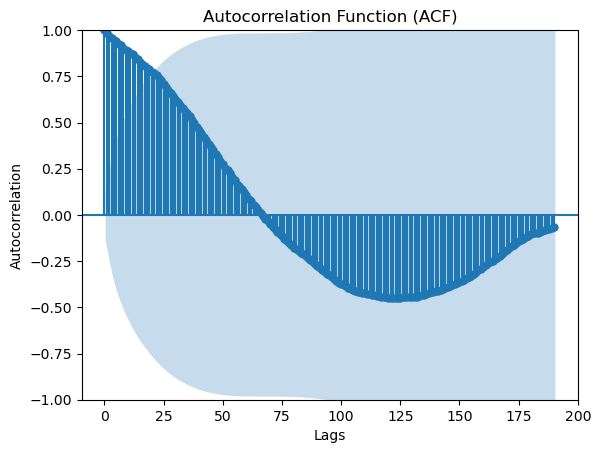

In [7]:
plt.figure(figsize=(12, 30))
plot_acf(pos_pp['review_id'].values.squeeze(), lags=190)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(False)
plt.show()

<Figure size 1200x600 with 0 Axes>

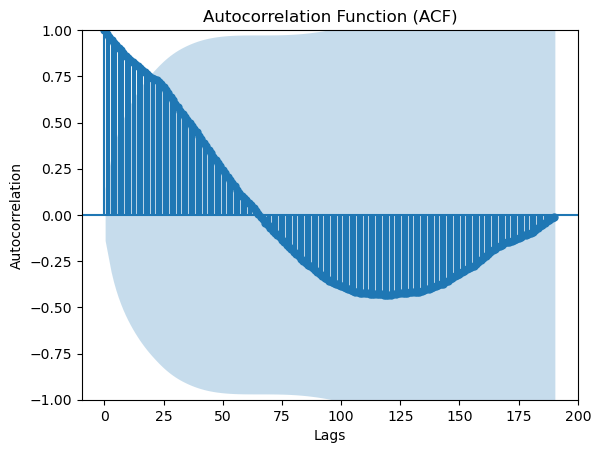

In [8]:
plt.figure(figsize=(12, 6))
plot_acf(neg_pp['review_id'].values.squeeze(), lags=190)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(False)
plt.show()

<Figure size 1200x600 with 0 Axes>

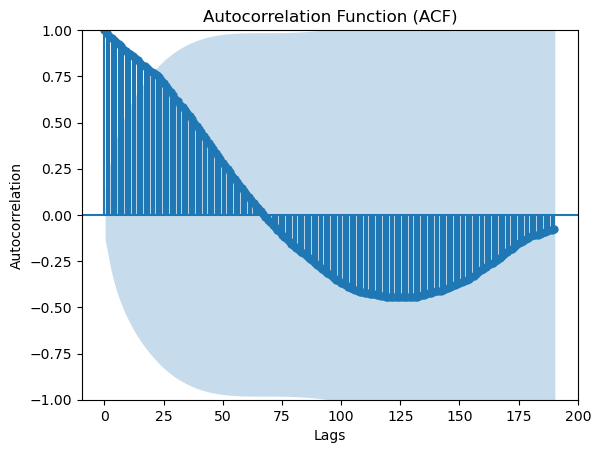

In [9]:
plt.figure(figsize=(12, 6))
plot_acf(reviews_per_month['count'].values.squeeze(), lags=190)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(False)
plt.show()

## 2.2. EDA - Times series for Number of Reviews (regardless of the sentiment)

In [10]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Number of reviews', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

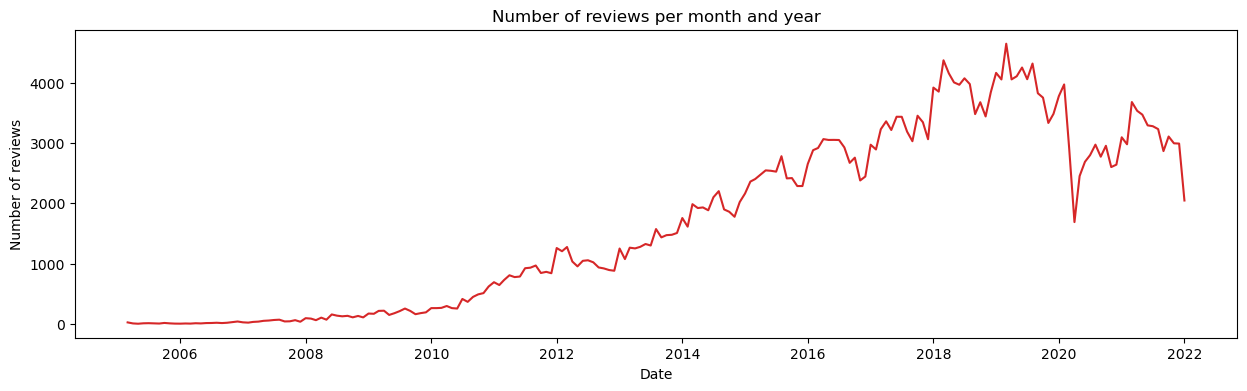

In [11]:
plot_df(x=reviews_per_month['date'], y=reviews_per_month['count'], title='Number of reviews per month and year')

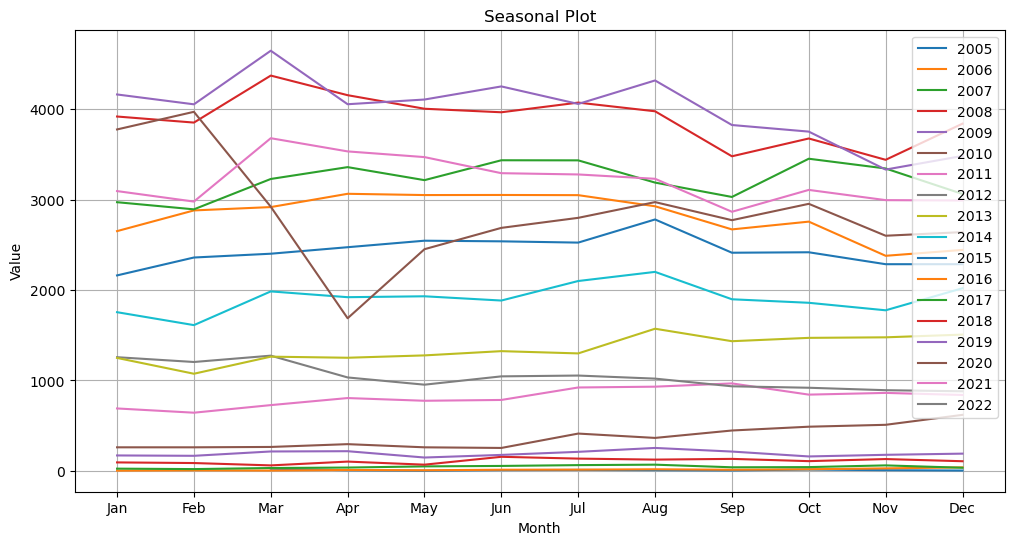

In [12]:
utils.SeasonalPlot(reviews_per_month)

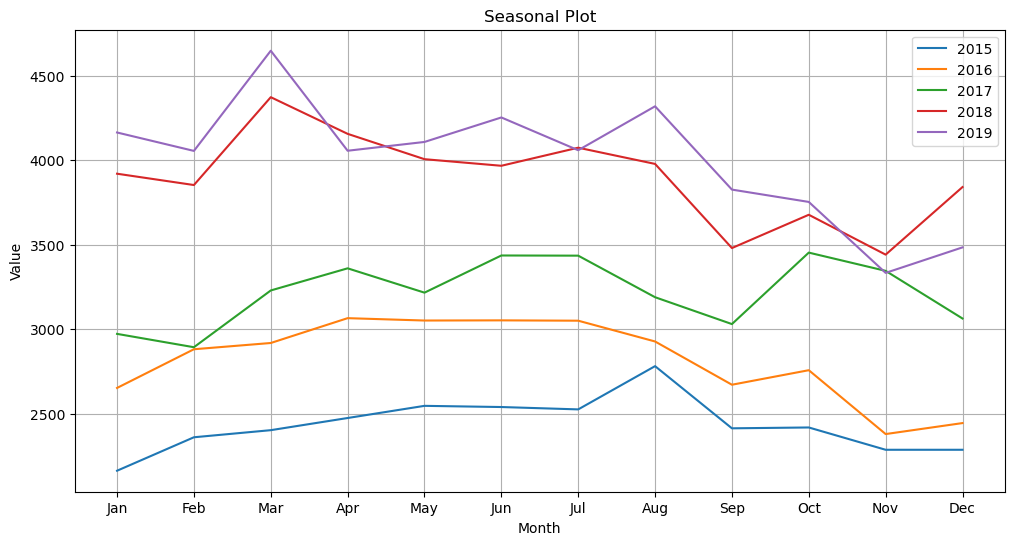

In [13]:
utils.SeasonalPlot(reviews_per_month, [2015, 2016, 2017, 2018, 2019])

### 2.2.1. EDA - Times series for Top 5 businesses in Tucson with the highest ammount of reviews 

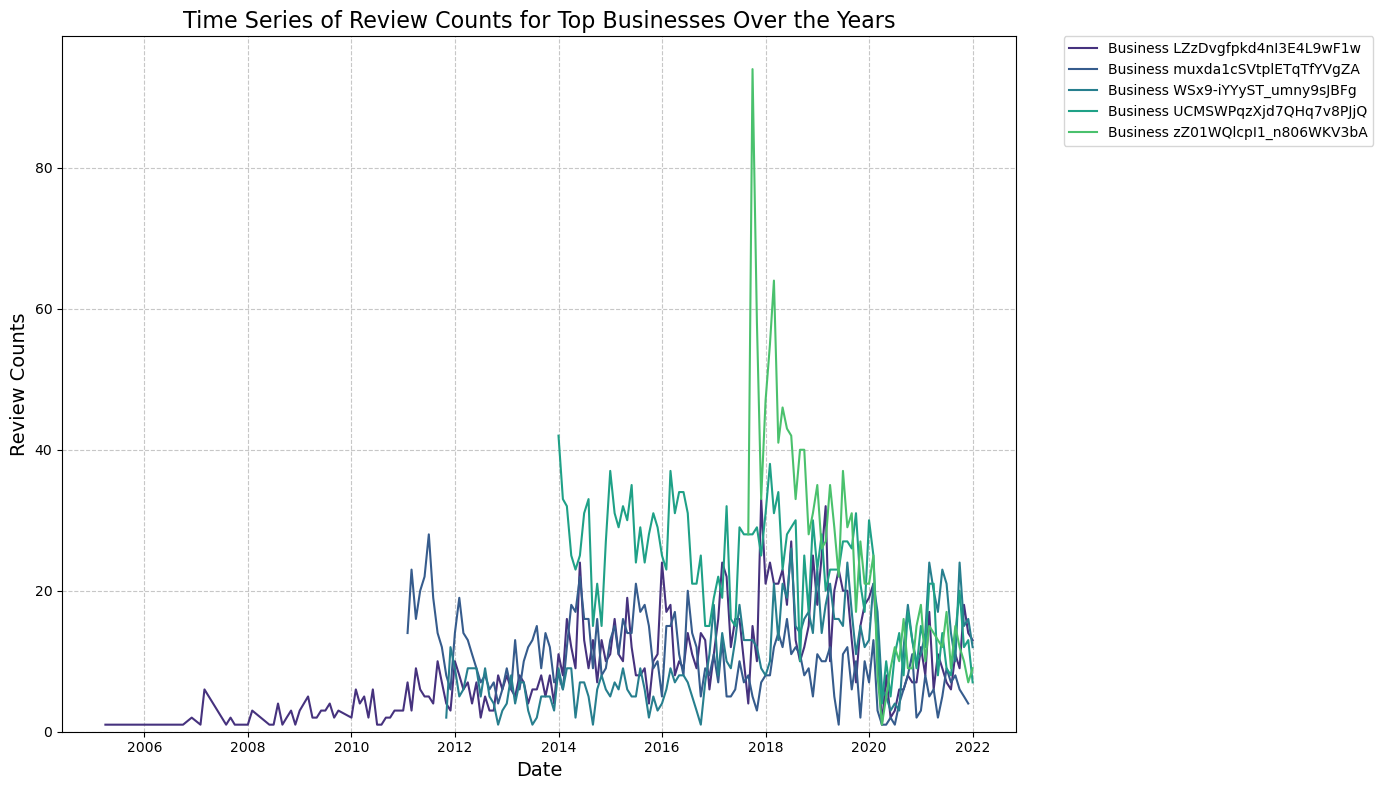

In [14]:
# Assuming you have a list of top businesses called 'top_businesses_list'
top_businesses_series = count_rev_bus.groupby(['business_id'])['count'].sum().sort_values(ascending=False).head(5)
utils.plot_top_businesses_over_time(count_rev_bus, top_businesses_series)

### 2.2.2. EDA - Times series decomposition

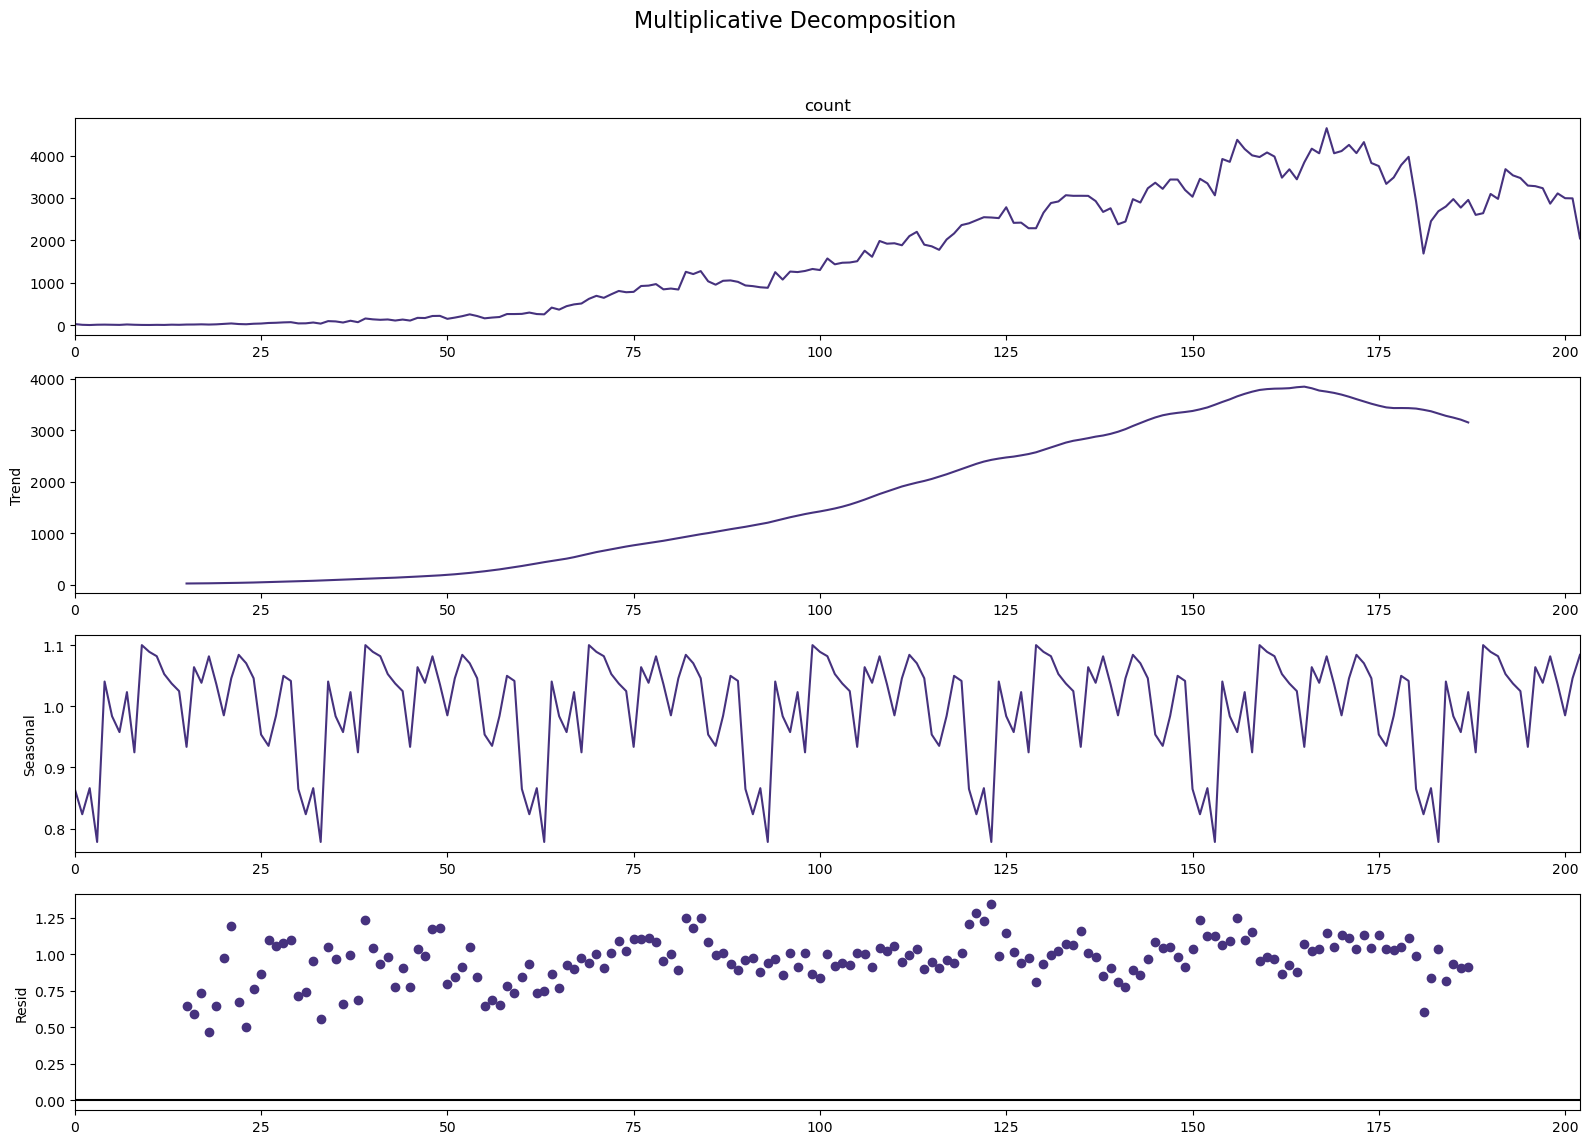

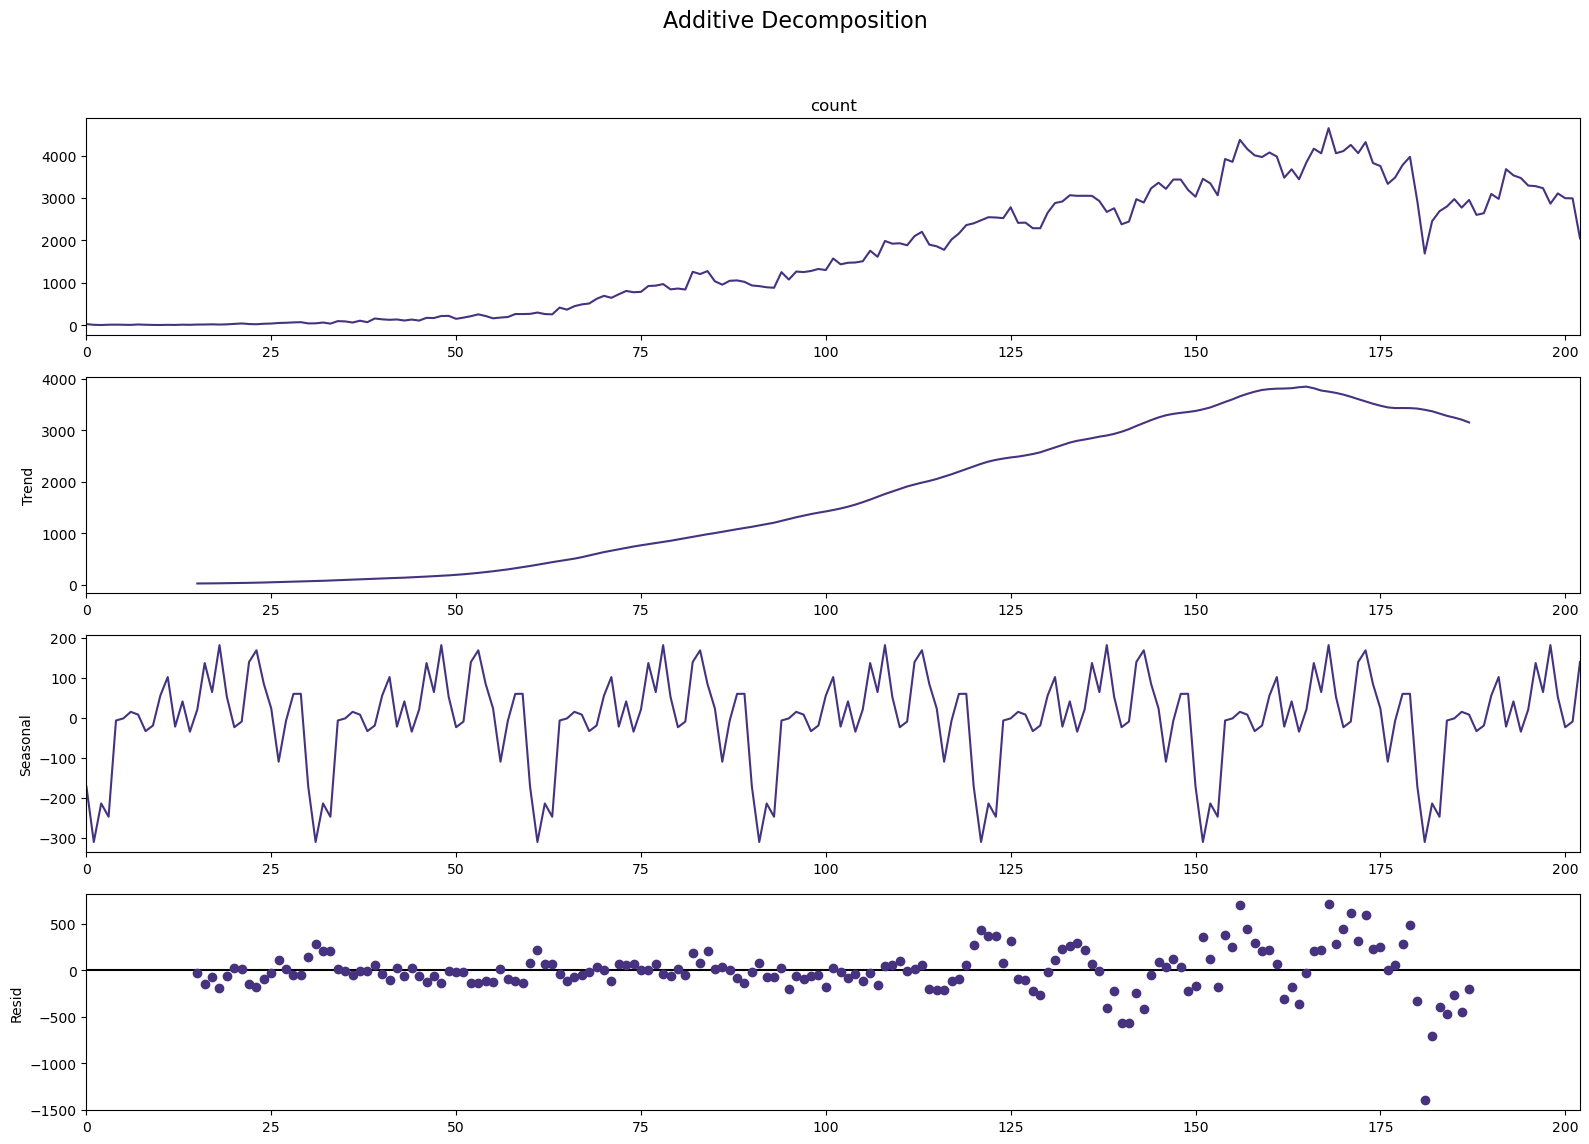

In [15]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(reviews_per_month['count'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(reviews_per_month['count'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## EDA 2.3. - Time series of review counts segregated by sentiments

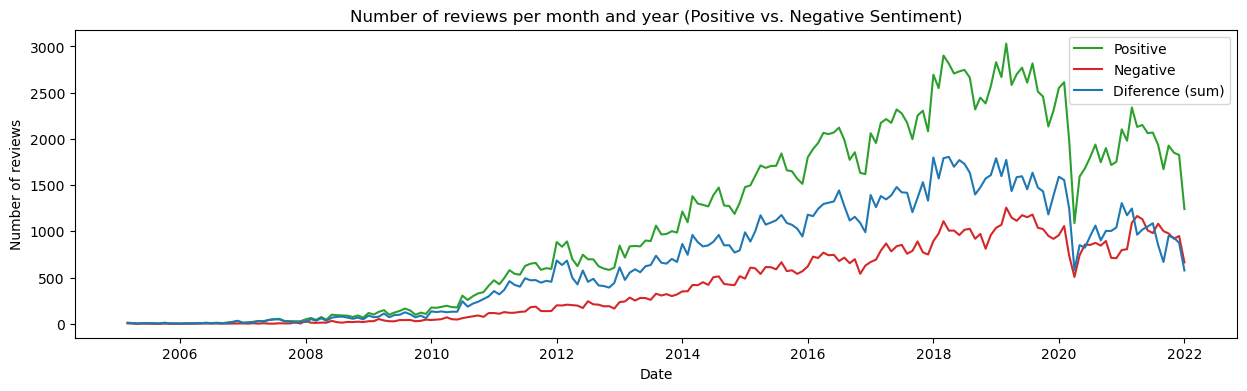

In [16]:
#Visualize the number of reviews per month and year (Positive vs. Negative Sentiment) and the sentiment sum 
utils.plot_df(x_pos=pos_pp['date'], y_pos=pos_pp['review_id'],
              x_neg=neg_pp['date'], y_neg=neg_pp['review_id'],
              x_df_num=df_num['date'], y_df_num=df_num['sentiment_count_diff'],
              title='Number of reviews per month and year (Positive vs. Negative Sentiment)')

### EDA 2.3.1. - Time series decomposition

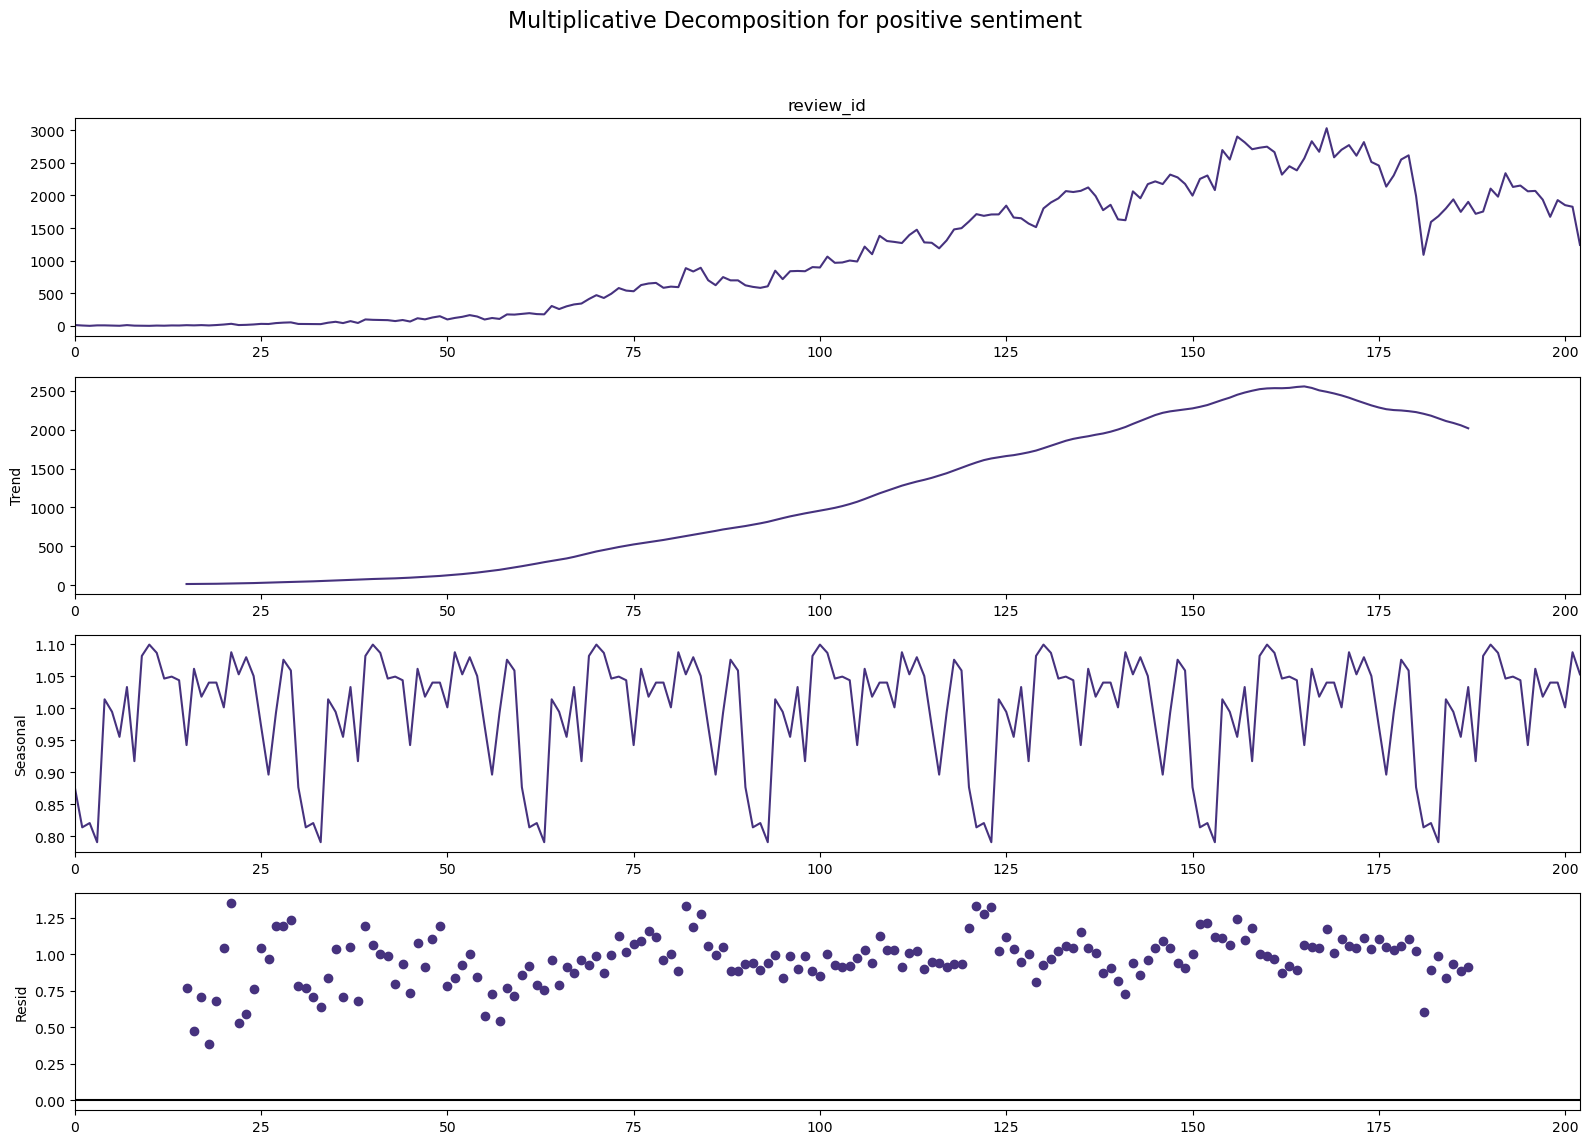

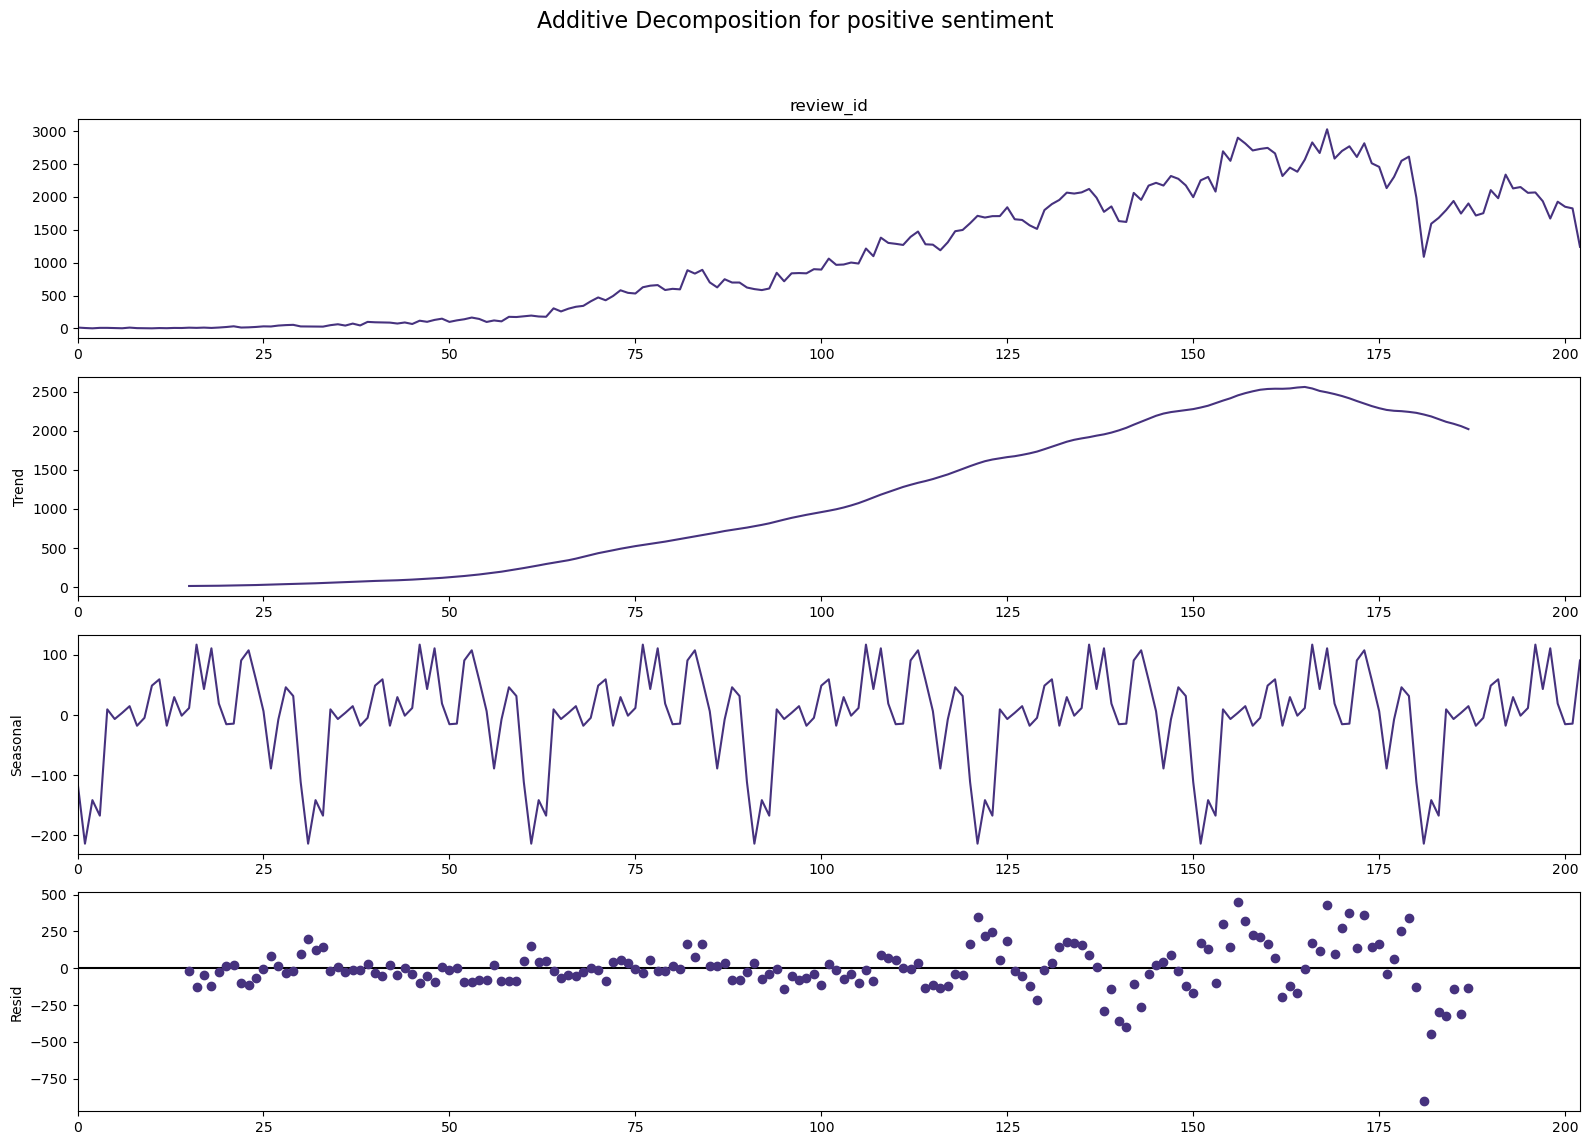

In [17]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(pos_pp['review_id'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(pos_pp['review_id'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition for positive sentiment', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition for positive sentiment', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

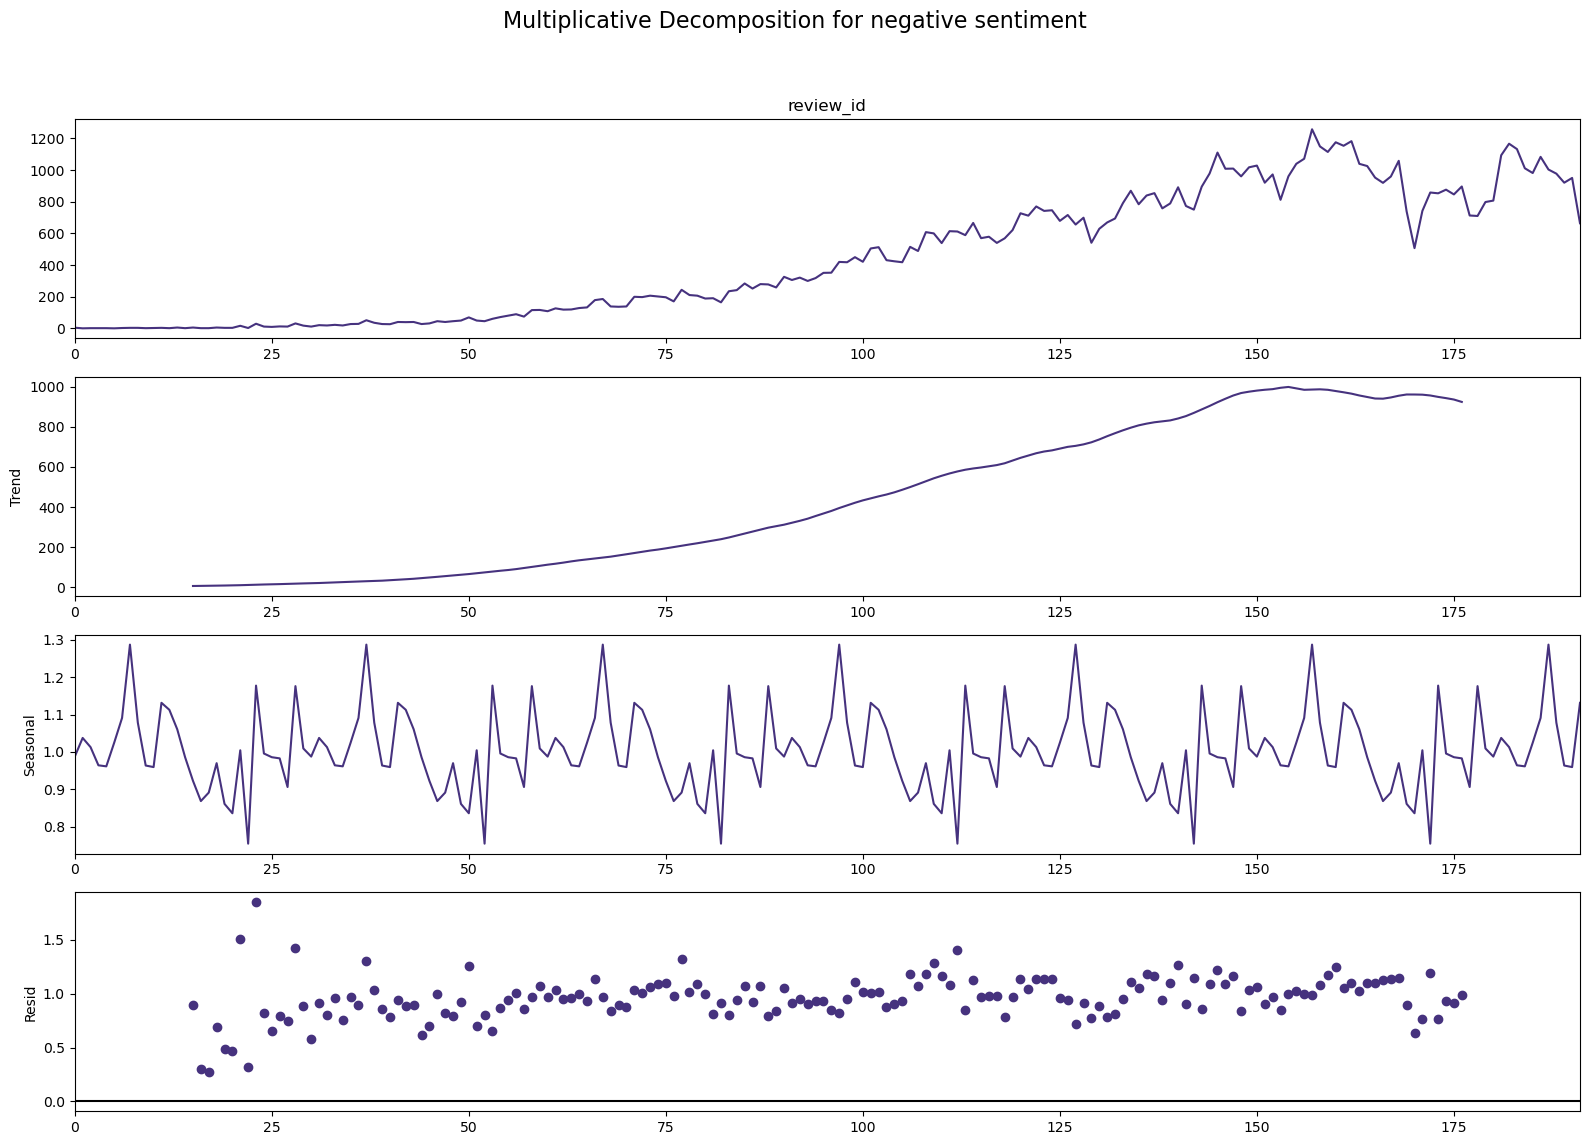

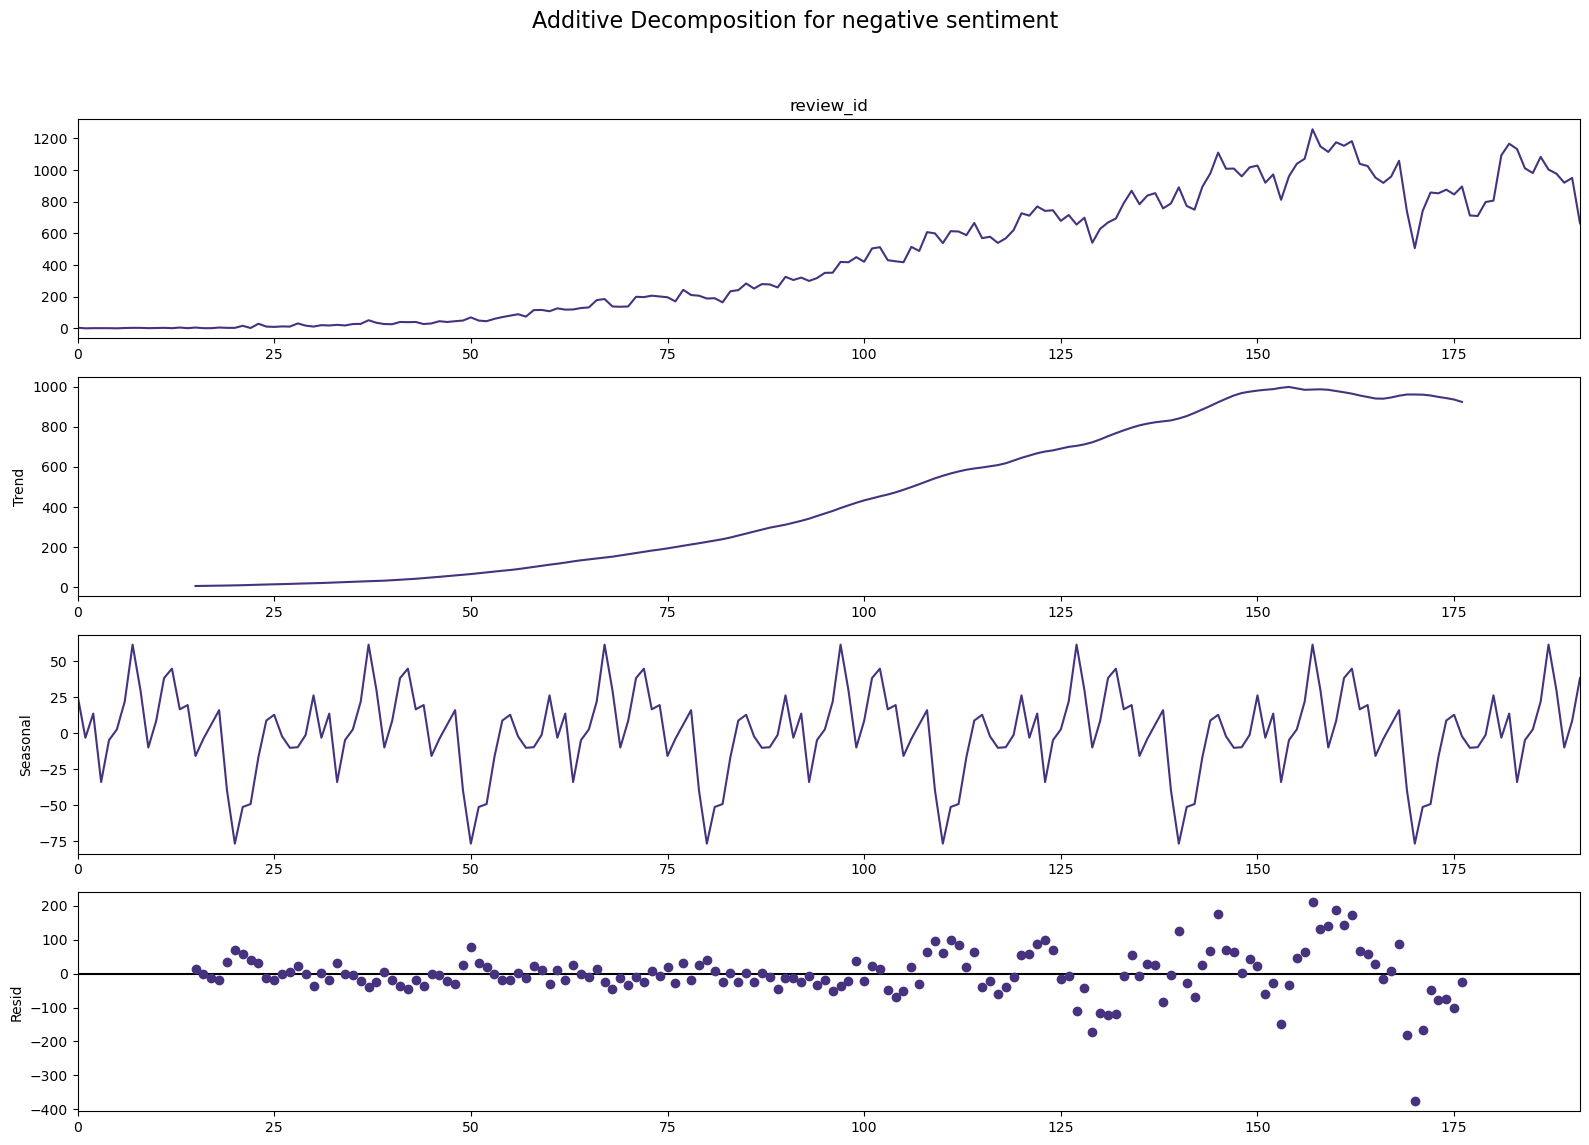

In [18]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(neg_pp['review_id'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(neg_pp['review_id'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition for negative sentiment', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition for negative sentiment', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

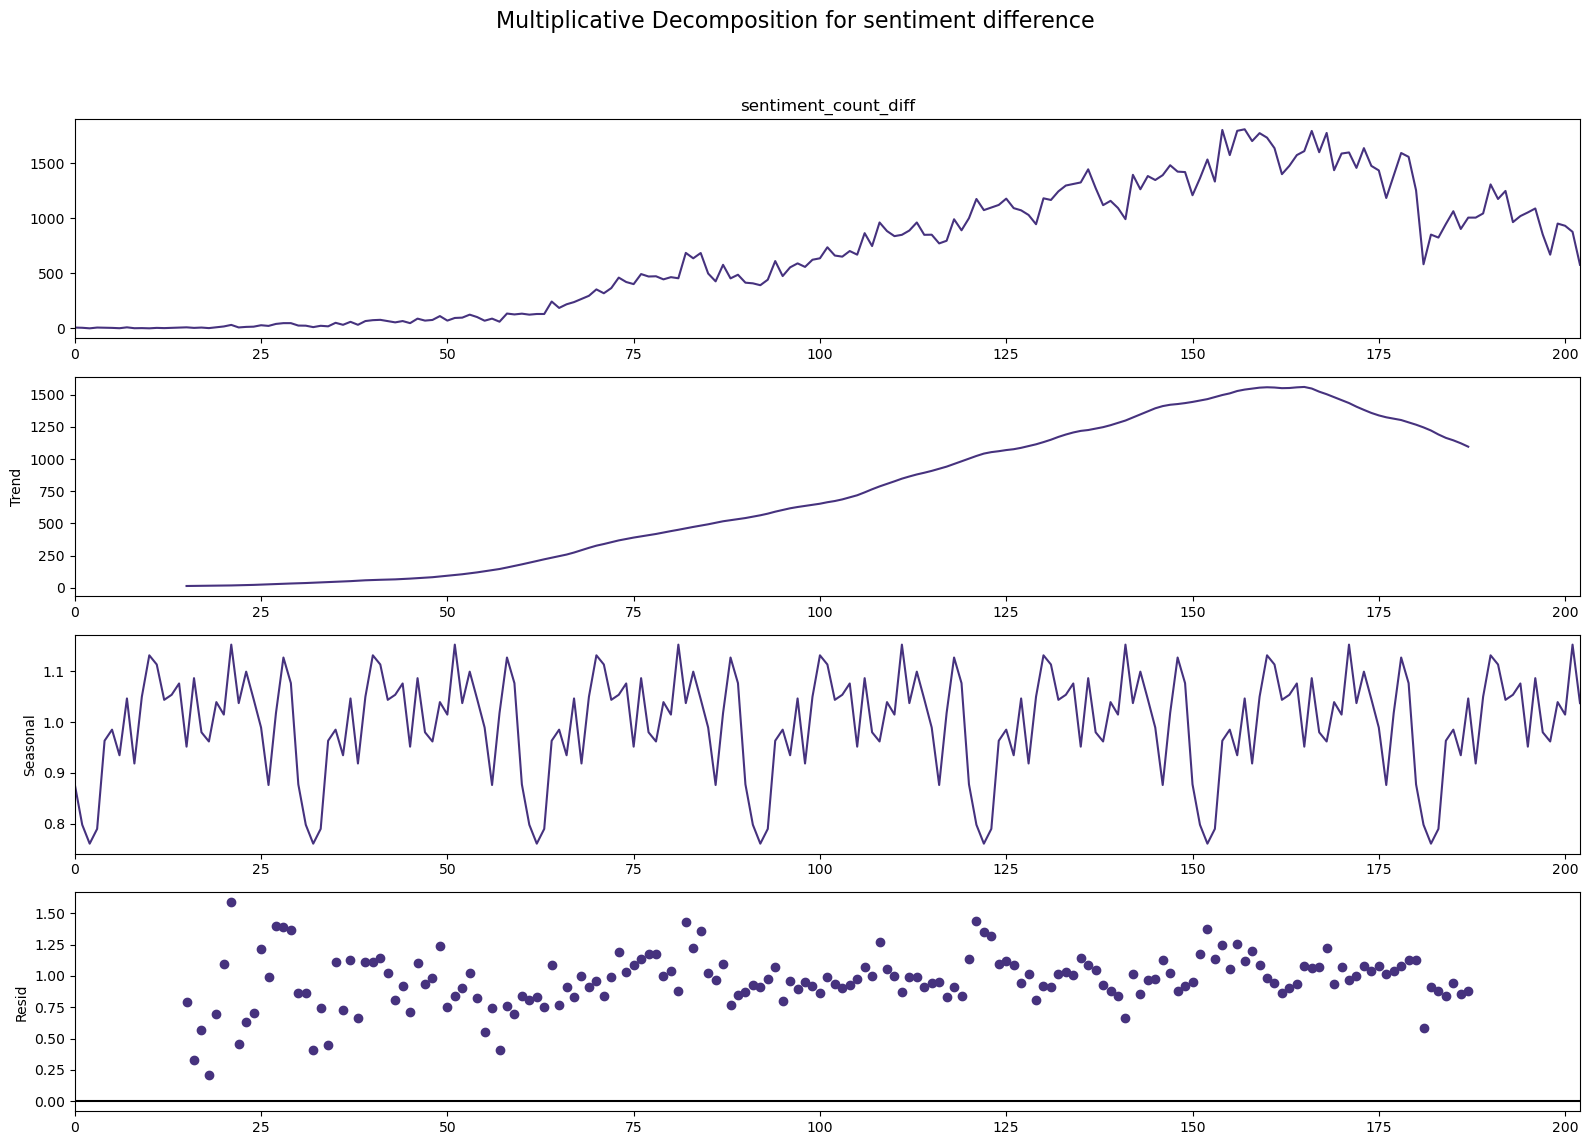

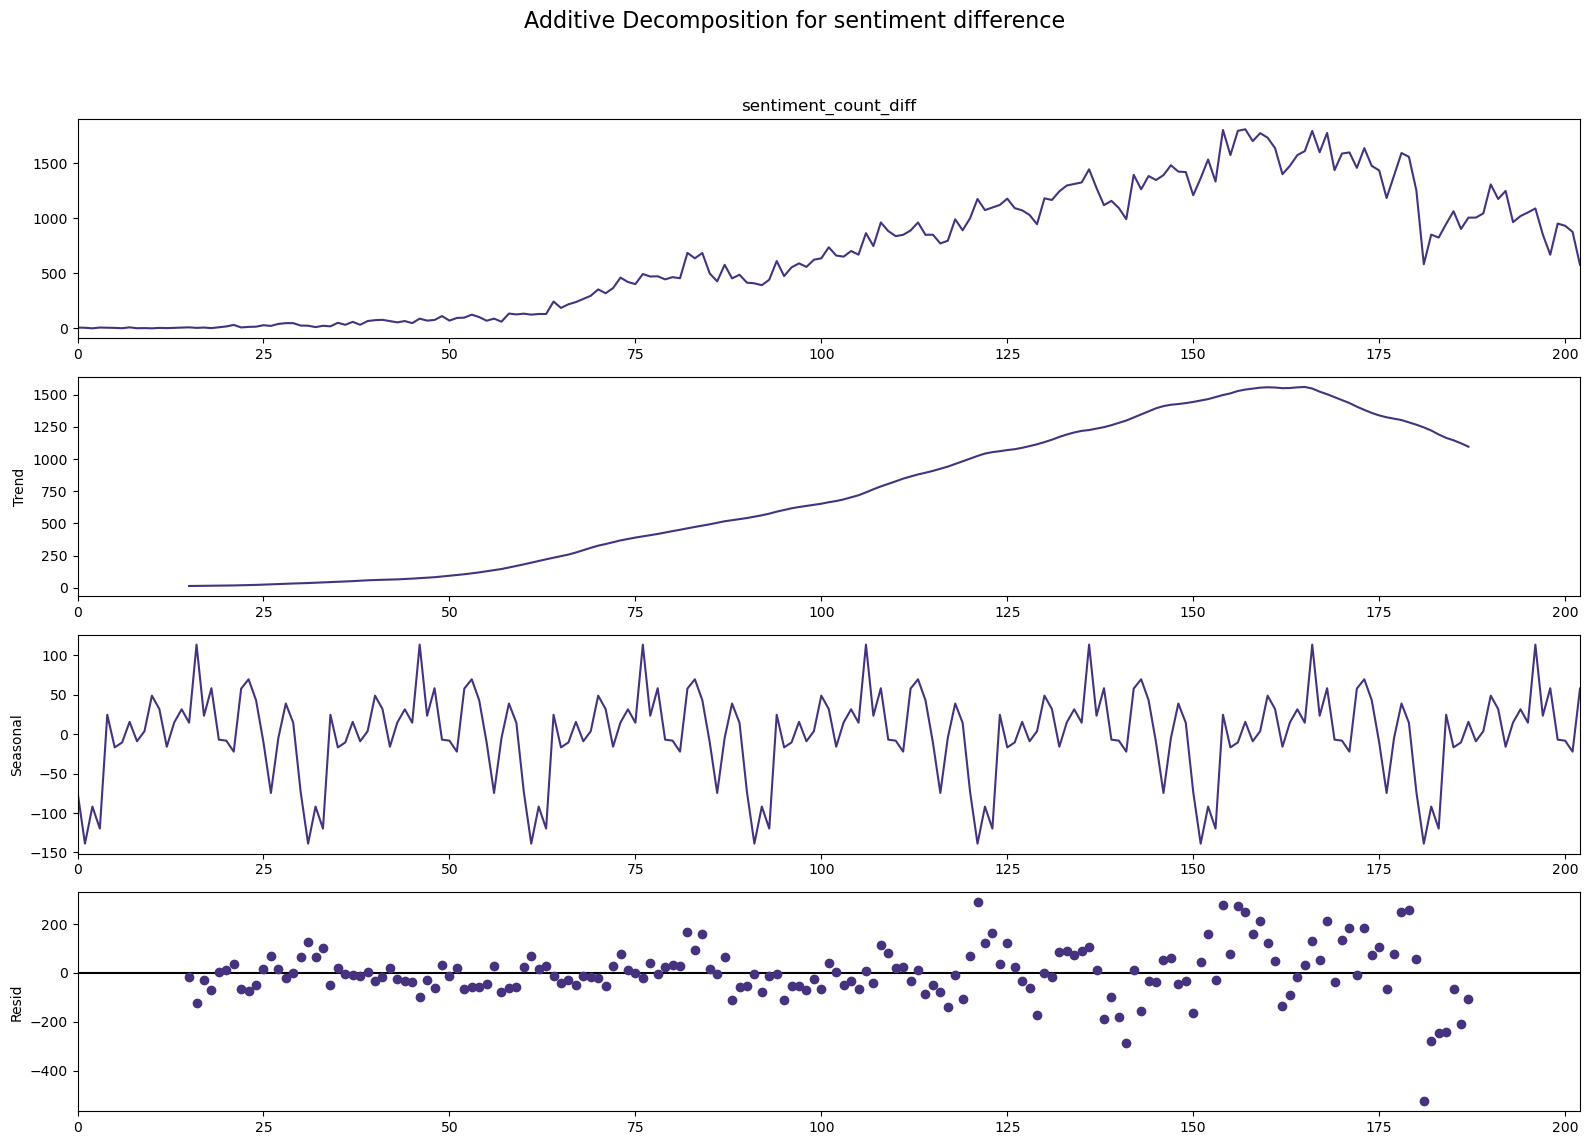

In [19]:
##### Decomposition of a time series can be performed by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual term.
##The seasonal_decompose in statsmodels implements this conveniently.

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_num['sentiment_count_diff'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(df_num['sentiment_count_diff'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition for sentiment difference', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition for sentiment difference', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. DM - Data Modeling

In [20]:
pos_train = pos_pp[pos_pp['date'] < '2021-01-01']
pos_test = pos_pp[pos_pp['date'] >= '2021-01-01']

neg_train = neg_pp[neg_pp['date'] < '2021-01-01']
neg_test = neg_pp[neg_pp['date'] >= '2021-01-01']

## 3.1. DM - Baseline

### 3.1.1. DM - Baseline - Mean

In [21]:
pos_mean = pos_train['review_id'].mean()
neg_mean = neg_train['review_id'].mean()

### 3.1.2. DM - Baseline - Naive

In [22]:
pos_naive = pos_train['review_id'].values[-1]
neg_naive = neg_train['review_id'].values[-1]

## 3.2. DM - Exponential Smoothing

In [23]:
alpha = 0.9
beta = 0.9
gamma = 0.9

### 3.2.1. DM - Exponential Smoothing - Simple Exponential Smoothing

In [24]:
SimpleExpSmoothing_pos_model, SimpleExpSmoothing_pos_results = utils.ExponentialSmoothingModeling(model_type = 'simple', 
                                                                                    sentiment_data = pos_train, 
                                                                                    alpha = alpha)

In [25]:
SimpleExpSmoothing_neg_model, SimpleExpSmoothing_neg_results = utils.ExponentialSmoothingModeling(model_type = 'simple', 
                                                                                                  sentiment_data = neg_train, 
                                                                                                  alpha = alpha)

### 3.2.2. DM - Exponential Smoothing - Holt Exponential Smoothing

In [26]:
Holt_NotDamped_pos_model, Holt_NotDamped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                            sentiment_data = pos_train,
                                                                            alpha = alpha, 
                                                                            beta = beta,
                                                                            damped = False)

Holt_Damped_pos_model, Holt_Damped_neg_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                      sentiment_data = pos_train, 
                                                                      alpha = alpha, 
                                                                      beta = beta,
                                                                      damped = True)

In [27]:
Holt_NotDamped_neg_model, Holt_NotDamped_neg_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                          sentiment_data = neg_train,
                                                                                          alpha = alpha, 
                                                                                          beta = beta,
                                                                                          damped = False)

Holt_Damped_neg_model, Holt_Damped_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                sentiment_data = neg_train, 
                                                                                alpha = alpha, 
                                                                                beta = beta,
                                                                                damped = True)

### 3.2.3. DM - Exponential Smoothing - Holt-Winters Exponential Smoothing

In [28]:
HoltWinters_Add_NotDamped_pos_model, HoltWinters_Add_NotDamped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                          sentiment_data = pos_train, 
                                                                                          decomposition_type = 'additive',
                                                                                          alpha = alpha, 
                                                                                          beta = beta, 
                                                                                          gamma = gamma,
                                                                                          damped = False)

HoltWinters_Add_Damped_pos_model, HoltWinters_Add_Damped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                    sentiment_data = pos_train, 
                                                                                    alpha = alpha, 
                                                                                    beta = beta, 
                                                                                    gamma = gamma,
                                                                                    decomposition_type = 'additive', 
                                                                                    damped = True)


HoltWinters_Multi_NotDamped_pos_model, HoltWinters_Multi_NotDamped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                          sentiment_data = pos_train, 
                                                                                          decomposition_type = 'multiplicative',
                                                                                          alpha = alpha, 
                                                                                          beta = beta, 
                                                                                          gamma = gamma,
                                                                                          damped = False)

HoltWinters_Multi_Damped_pos_model, HoltWinters_Multi_Damped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                    sentiment_data = pos_train, 
                                                                                    alpha = alpha, 
                                                                                    beta = beta, 
                                                                                    gamma = gamma,
                                                                                    decomposition_type = 'multiplicative', 
                                                                                    damped = True)

In [29]:
HoltWinters_Add_NotDamped_neg_model, HoltWinters_Add_NotDamped_neg_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                                        sentiment_data = neg_train, 
                                                                                                        decomposition_type = 'additive',
                                                                                                        alpha = alpha, 
                                                                                                        beta = beta, 
                                                                                                        gamma = gamma,
                                                                                                        damped = False)

HoltWinters_Add_Damped_neg_model, HoltWinters_Add_Damped_neg_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                                  sentiment_data = neg_train, 
                                                                                                  alpha = alpha, 
                                                                                                  beta = beta, 
                                                                                                  gamma = gamma,
                                                                                                  decomposition_type = 'additive', 
                                                                                                  damped = True)


HoltWinters_Multi_NotDamped_neg_model, HoltWinters_Multi_NotDamped_neg_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                                        sentiment_data = neg_train, 
                                                                                                        decomposition_type = 'multiplicative',
                                                                                                        alpha = alpha, 
                                                                                                        beta = beta, 
                                                                                                        gamma = gamma,
                                                                                                        damped = False)

HoltWinters_Multi_Damped_neg_model, HoltWinters_Multi_Damped_neg_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                                  sentiment_data = neg_train, 
                                                                                                  alpha = alpha, 
                                                                                                  beta = beta, 
                                                                                                  gamma = gamma,
                                                                                                  decomposition_type = 'multiplicative', 
                                                                                                  damped = True)

## 3.3. DM - ARIMA

In [30]:
# fit model
model_pos = ARIMA(pos_train['review_id'], order=(12,12,6))  #p,d,q
results_pos = model_pos.fit()
# summary of fit model
print(results_pos.summary())

/Users/luish/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/luish/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              review_id   No. Observations:                  190
Model:               ARIMA(12, 12, 6)   Log Likelihood               -1468.389
Date:                Tue, 03 Oct 2023   AIC                           2974.779
Time:                        19:24:30   BIC                           3035.233
Sample:                             0   HQIC                          2999.294
                                - 190                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8546      0.046    -40.347      0.000      -1.945      -1.765
ar.L2         -1.6076      0.073    -22.144      0.000      -1.750      -1.465
ar.L3         -0.4684      0.112     -4.168      0.0

In [31]:
# fit model
model_neg = ARIMA(neg_train['review_id'], order=(12,12,6))  #p,d,q
results_neg = model_neg.fit()
# summary of fit model
print(results_neg.summary())

/Users/luish/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/luish/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              review_id   No. Observations:                  179
Model:               ARIMA(12, 12, 6)   Log Likelihood                   0.000
Date:                Tue, 03 Oct 2023   AIC                             38.000
Time:                        19:26:45   BIC                             97.242
Sample:                             0   HQIC                            62.045
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -6.3672         -0        inf      0.000      -6.367      -6.367
ar.L2        -15.6215         -0        inf      0.000     -15.622     -15.622
ar.L3        -15.1224   1.57e-07   -9.6e+07      0.0

/Users/luish/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:2979: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/Users/luish/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: invalid value encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/luish/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


## 3.4. DM - Regression

In [32]:
pos_pp_reg_train = pos_pp_reg[pos_pp_reg['date'] < '2021-01-01']
pos_pp_reg_test = pos_pp_reg[pos_pp_reg['date'] >= '2021-01-01']

neg_pp_reg_train = neg_pp_reg[pos_pp_reg['date'] < '2021-01-01']
neg_pp_reg_test = neg_pp_reg[neg_pp_reg['date'] >= '2021-01-01']

X_train_pos, y_train_pos = pos_pp_reg_train.drop(columns=['review_id', 'date']), pos_pp_reg_train['review_id']
X_train_neg, y_train_neg = neg_pp_reg_train.drop(columns=['review_id', 'date']), neg_pp_reg_train['review_id']

scaler_pos = StandardScaler()
scaler_pos.fit(X_train_pos)
X_train_pos = scaler_pos.transform(X_train_pos)

scaler_neg = StandardScaler()
scaler_neg.fit(X_train_neg)
X_train_neg = scaler_neg.transform(X_train_neg)

/var/folders/7h/r2qhkyrj6x951_n8cq54_49w0000gn/T/ipykernel_7787/3158071143.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neg_pp_reg_train = neg_pp_reg[pos_pp_reg['date'] < '2021-01-01']


In [33]:
model_pos = LinearRegression()
LineaRegression_pos = model_pos.fit(X_train_pos, y_train_pos)

model_neg = LinearRegression()
LineaRegression_neg = model_neg.fit(X_train_neg, y_train_neg)

In [34]:
display(LineaRegression_pos.score(X_train_pos, y_train_pos))
display(LineaRegression_neg.score(X_train_neg, y_train_neg))

0.9863184368163861

0.9772134275652266

# 4. ME - Model Evaluation